# TUIA NLP 2025 TRABAJO PRÁCTICO FINAL

Objetivo del trabajo práctico
Desarrollar un asistente virtual especializado en información de una empresa de electrodomésticos que responde preguntas sobre usos de productos, precios, reseñas de usuarios, recomendaciones.

# EJERCICIO 1 - RAG
Requisitos y pasos:
A partir de los datos dados generar tres tipos de fuentes de datos y definir/justificar su contenido:
- Vectorial
- Tabular
- Grafos

In [3]:
%%capture
# ==========================================
# CONFIGURACIÓN DEL ENTORNO
# ==========================================

# 1. Descarga de Datos
!gdown 1KfpXVicIr9ZvomVkZCAiRpcTYD8d7B77
!unzip -o -q fuentes_de_informacion-*.zip

!gdown --id 1n3t-5TDTiYO_S2EF82TgM4cl_xv2U8v8
!unzip -o -q chroma_db_backup_v3.zip -d chroma_data

# 2. INSTALACIONES (Orden específico para evitar conflictos)
# A) Primero arreglamos la base numérica (numpy/pandas) para evitar el error "dtype size"
!pip install -U -q "numpy>=1.26.0" "pandas>=2.0.0" "scikit-learn"

# B) Instalamos LangChain pero BLOQUEAMOS la versión que rompe la compatibilidad
!pip install -U -q "langchain-core<0.3.0" langchain-community langchain-google-genai

# C) Instalamos el resto de las herramientas (Bases de datos y utilidades)
!pip install -U -q langchain-chroma langchain-text-splitters sentence-transformers chromadb kuzu rank_bm25 google-generativeai

print(" INSTALACIÓN COMPLETADA.")
print(" IMPORTANTE: 'Reiniciar sesión' para aplicar los cambios.")

In [1]:
%%capture
# REPARACIÓN DE VERSIONES
!pip uninstall -y langchain langchain-core langchain-google-genai
!pip install -U -q "langchain-core<0.3.0" "langchain-community<0.3.0" langchain-google-genai

# BASE DE DATOS VECTORIAL

In [2]:
# Importaciones
import glob
import zipfile
import shutil
import re
import numpy as np
from pathlib import Path
from tqdm import tqdm
import sqlite3
import os
import pandas as pd
from google.colab import drive

# LangChain & Chroma Imports
from langchain_text_splitters import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter
from langchain_core.documents import Document
from langchain_chroma import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import List, Tuple, Dict, Optional
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


# CONFIGURACIÓN DEL MODELO DE EMBEDDINGS (HuggingFace)
print(f" Cargando modelo de Embeddings: intfloat/multilingual-e5-small")

embedding_model = HuggingFaceEmbeddings(
    model_name="intfloat/multilingual-e5-small",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True}
)

# FUNCION DE UTILIDAD
def limpiar_texto(texto: str) -> str:
    if not texto: return ""
    texto = texto.replace("\ufeff", "").replace("\r", " ").replace("\t", " ")
    texto = re.sub(r" {2,}", " ", texto)
    texto = texto.replace("\n\n\n", "\n\n")
    return texto.strip()

 Cargando modelo de Embeddings: intfloat/multilingual-e5-small


/tmp/ipython-input-2294608280.py:28: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embedding_model = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [3]:
# API KEY
from google.colab import userdata
api_key = userdata.get('GOOGLE_KEY')

In [4]:
# CONFIGURACIÓN DEL MODELO DEL LLM

# --- PEGA TU API KEY AQUÍ ---
# Consíguela gratis en: https://aistudio.google.com/app/apikey
os.environ["GOOGLE_API_KEY"] = api_key

print(" Conectando a Gemini 2.0 Flash...")

# Definimos el modelo del LLM
try:
    llm_gemini = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash", # Modelo rápido y potente
        temperature=0             # Temperatura 0 para máxima precisión
    )
    # Prueba rápida
    print(f" Conexión Exitosa: {llm_gemini.invoke('Hola').content}")
except Exception as e:
    print(f" Error de API Key: {e}")

 Conectando a Gemini 2.0 Flash...
 Conexión Exitosa: ¡Hola! ¿En qué puedo ayudarte hoy?



In [5]:
#Carga y Descompresión de Datos

# ============================================
# PREPARACIÓN DE DATOS
# ============================================

# Buscamos el ZIP automáticamente
zips = glob.glob("/content/fuentes_de_informacion*.zip")
ROOT = Path("/content/fuentes_de_informacion")

if zips:
    zip_path = zips[0]
    # Solo descomprimimos si la carpeta no existe
    if not os.path.exists(ROOT):
        print(f" Detectado archivo fuente: {os.path.basename(zip_path)}")
        print("   -> Descomprimiendo archivos...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("/content/")
        print(" Carga de datos completada exitosamente.")
    else:
        print("ℹ Los datos ya se encuentran cargados en el entorno.")
else:
    print(" No se encontró el archivo .zip de origen.")

ℹ Los datos ya se encuentran cargados en el entorno.


In [6]:
# ============================================
# RUTAS Y VERIFICACIÓN
# ============================================
DIR_MANUALES = ROOT / "manuales_productos"
DIR_RESENAS = ROOT / "resenas_usuarios"
RUTA_CSV = ROOT / "productos.csv"

# Rutas para ChromaDB y salidas
RUTA_CHROMA = "/content/chroma_db_final"

# Verificación rápida
cant_manuales = len(glob.glob(str(DIR_MANUALES / "*.md")))
cant_resenas = len(glob.glob(str(DIR_RESENAS / "*.txt")))
existe_csv = os.path.exists(RUTA_CSV)

print("\n ESTADO DEL DATASET:")
print(f"   - Manuales (.md): {cant_manuales} documentos.")
print(f"   - Reseñas (.txt): {cant_resenas} documentos.")
print(f"   - Tabla SQL (.csv): {'Disponible' if existe_csv else 'Faltante'}")


 ESTADO DEL DATASET:
   - Manuales (.md): 50 documentos.
   - Reseñas (.txt): 5015 documentos.
   - Tabla SQL (.csv): Disponible


In [7]:
#Procesamiento de Documentos

docs_totales = []

# ============================================
# 1. PROCESAR MANUALES (Markdown)
# ============================================
print(" Procesando Manuales...")
headers_to_split_on = [("#", "Titulo_Principal"), ("##", "Subtitulo"), ("###", "Seccion")]
md_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

md_files = glob.glob(os.path.join(DIR_MANUALES, "*.md"))

for file_path in md_files:
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        chunks = md_splitter.split_text(text)

        for chunk in chunks:
            chunk.metadata["source"] = os.path.basename(file_path)
            chunk.metadata["tipo"] = "manual"  # Etiqueta clave

        docs_totales.extend(chunks)
    except Exception as e:
        print(f" Error en manual {os.path.basename(file_path)}: {e}")

print(f"   -> {len(docs_totales)} fragmentos de manuales acumulados.")

# ============================================
# 2. PROCESAR RESEÑAS (Texto Plano)
# ============================================
print(" Procesando Reseñas...")
txt_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

txt_files = glob.glob(os.path.join(DIR_RESENAS, "*.txt"))
count_resenas = 0

for file_path in txt_files:
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        chunks = txt_splitter.create_documents([text])

        for chunk in chunks:
            chunk.metadata["source"] = os.path.basename(file_path)
            chunk.metadata["tipo"] = "resena" # Etiqueta clave

        docs_totales.extend(chunks)
        count_resenas += len(chunks)
    except Exception as e:
        print(f" Error en reseña {os.path.basename(file_path)}: {e}")

print(f"   -> {count_resenas} reseñas procesadas.")
print(f" TOTAL DOCUMENTOS LISTOS PARA VECTORIZAR: {len(docs_totales)}")

 Procesando Manuales...
   -> 1014 fragmentos de manuales acumulados.
 Procesando Reseñas...
   -> 5015 reseñas procesadas.
 TOTAL DOCUMENTOS LISTOS PARA VECTORIZAR: 6029


In [8]:
# Codigo con el que se creo la base de datos en chroma, comentado ya que se recupera el archivo desde drive o localmete
# # ============================================
# # CREAR VECTOR STORE & BACKUP
# # ============================================

# from google.colab import drive


# # 1. Definimos una RUTA NUEVA para evitar conflictos de versiones
# # Al cambiar el nombre, evitamos que lea archivos viejos corruptos
# RUTA_CHROMA = "/content/chroma_db_v3_clean"

# # Limpieza por si acaso ejecutas esto varias veces
# if os.path.exists(RUTA_CHROMA):
#     shutil.rmtree(RUTA_CHROMA)
#     print(" Carpeta limpia.")

# print(f" Indexando {len(docs_totales)} documentos en: {RUTA_CHROMA}...")

# try:
#     # 2. Crear DB
#     vector_db = Chroma.from_documents(
#         documents=docs_totales,
#         embedding=embedding_model,
#         persist_directory=RUTA_CHROMA,
#         collection_name="manuales_db" # Es buena práctica ponerle nombre
#     )
#     print(" Base de datos creada exitosamente en memoria local.")

#     # 3. Respaldo en Drive
#     print("\n Iniciando respaldo en Google Drive...")

#     if not os.path.exists('/content/drive'):
#         drive.mount('/content/drive')

#     # Nombre del archivo zip temporal
#     zip_base_name = "/content/chroma_backup_v3"

#     # Comprimimos la carpeta nueva
#     shutil.make_archive(zip_base_name, 'zip', RUTA_CHROMA)

#     # Movemos al Drive
#     destino_drive = "/content/drive/MyDrive/chroma_db_backup_v3.zip"
#     shutil.copy(f"{zip_base_name}.zip", destino_drive)

#     print(f" Respaldo guardado en: {destino_drive}")

# except Exception as e:
#     print(f" Error crítico: {e}")
#     print("Intenta reiniciar la sesión nuevamente si el error persiste.")

In [9]:
# Recuperamos la base vectorial de chroma cargada

# Definir la ruta donde descomprimimos
extract_path = "chroma_data"

# A veces el zip tiene una carpeta adentro (ej: chroma_data/chroma_db_backup/...)
# Este pequeño bloque busca dónde está el archivo sqlite3
if "chroma.sqlite3" not in os.listdir(extract_path):
    subcarpetas = [f.path for f in os.scandir(extract_path) if f.is_dir()]
    if subcarpetas:
        extract_path = subcarpetas[0] # Entramos a la subcarpeta si existe

print(f" Cargando base desde: {extract_path}")

# Cargamos la base
vector_db = Chroma(
    persist_directory=extract_path,
    embedding_function=embedding_model, # Asegúrate de tener esto definido antes
    collection_name="manuales_db"
)

print(f" Base cargada con {vector_db._collection.count()} documentos.")

 Cargando base desde: chroma_data
 Base cargada con 6029 documentos.


In [10]:
#Interfaz de Búsqueda
def buscar_fragmentos(consulta: str, filtros: Optional[Dict] = None, k: int = 4, imprimir: bool = True):
    """
    Busca los K fragmentos más parecidos usando el modelo E5.
    """
    # Ajuste para modelo E5
    query_ajustada = f"query: {consulta}"

    resultados = vector_db.similarity_search_with_score(
        query_ajustada, k=k, filter=filtros
    )

    if imprimir:
        print(f"\n CONSULTA: '{consulta}'")

        for i, (doc, score) in enumerate(resultados):
            source = doc.metadata.get('source', 'Desconocido')
            tipo = doc.metadata.get('tipo', 'general')
            print(f" Top {i+1} | Score: {score:.4f} | Tipo: {tipo}")
            print(f" Fuente: {source}")
            print(f" Texto: {doc.page_content[:300]}...")
            print("-" * 60)

    return resultados


In [11]:
# ==========================================
# COSULTAS DE EJEMPLO
# ==========================================
buscar_fragmentos("¿plancha?", k=3)

buscar_fragmentos("batidora", k=2)


 CONSULTA: '¿plancha?'
 Top 1 | Score: 0.2826 | Tipo: resena
 Fuente: resena_R01407.txt
 Texto: Fecha: 2025-05-24
Usuario: Delfina_García
Teléfono: +54 9 113 4135-3830
Producto: Plancha Seca (P0286)
Puntaje: 4/5
Provincia: Córdoba

Hola! Llegó rápido y funciona de maravilla con Plancha Seca. Lo compré hace varios meses y es muy resistente, además de preciso. Lo uso todos los días para el desay...
------------------------------------------------------------
 Top 2 | Score: 0.2880 | Tipo: resena
 Fuente: resena_R03802.txt
 Texto: Fecha: 2024-12-28
Usuario: Juan_Molina
Teléfono: +54 9 68 3999-6396
Producto: Centro de Planchado (P0293)
Puntaje: 2/5
Provincia: Mendoza

Hola! Lamentablemente debo decir que muy caro para lo que es con Centro de Planchado. Es muy pesado y inestable. No funciona como indica la publicidad. Cualquier...
------------------------------------------------------------
 Top 3 | Score: 0.2933 | Tipo: resena
 Fuente: resena_R01886.txt
 Texto: Fecha: 2025-08-06
Usuario: 

[(Document(id='0e71e53f-1db0-47ec-8f78-57a1b5414d27', metadata={'source': 'resena_R01452.txt', 'tipo': 'resena'}, page_content='Fecha: 2025-01-12\nUsuario: Milagros_Rivera\nTeléfono: +54 9 284 9660-8614\nProducto: Batidora de Mano (P0019)\nPuntaje: 4/5\nProvincia: San Luis\n\nLes cuento... Excelente producto, superó mis expectativas con Batidora de Mano. Lo compré hace varios meses y es muy económico, además de práctico. Mi familia está muy contenta con la compra. Saludos!'),
  0.2738367021083832),
 (Document(id='3c0d0be3-598f-4b48-9429-cc2d17d83ade', metadata={'tipo': 'resena', 'source': 'resena_R03618.txt'}, page_content='Fecha: 2024-01-31\nUsuario: Martina_Navarro\nTeléfono: +54 9 328 7377-2907\nProducto: Batidora de Pie II (P0021)\nPuntaje: 5/5\nProvincia: Neuquén\n\nLes cuento... Producto de primera calidad con Batidora de Pie II. Lo compré hace varios meses y es muy elegante, además de eficiente. También destaco que es práctico. Lo uso todos los días para cocinar. Eso es todo.'),

# BASE DE DATOS TABULAR

In [12]:
# ============================================
# 1. CONFIGURACIÓN Y CARGA DE LA BASE DE DATOS
# ============================================
print("--- Iniciando carga de datos SQL ---")

# Defino la carpeta donde están tus archivos
CARPETA_BASE = "fuentes_de_informacion"

# Verificación rápida: Listar archivos para asegurar que la carpeta existe
if os.path.exists(CARPETA_BASE):
    print(f" Archivos detectados en '{CARPETA_BASE}': {os.listdir(CARPETA_BASE)}")
else:
    print(f" ERROR: No encuentro la carpeta '{CARPETA_BASE}'. Verifica el nombre exacto.")

# Conexión a base de datos en memoria
CONN_SQL = sqlite3.connect(':memory:')
CURSOR_SQL = CONN_SQL.cursor()

# Diccionario: Nombre del archivo -> Nombre de la tabla en SQL
archivos_config = {
    "productos.csv": "productos",
    "ventas_historicas.csv": "ventas",
    "inventario_sucursales.csv": "inventario",
    "devoluciones.csv": "devoluciones"
}

# Carga dinámica
for nombre_archivo, nombre_tabla in archivos_config.items():
    # Construimos la ruta completa: fuentes_de_informacion/archivo.csv
    ruta_completa = os.path.join(CARPETA_BASE, nombre_archivo)

    if os.path.exists(ruta_completa):
        try:
            df_temp = pd.read_csv(ruta_completa)

            # Limpieza básica de columnas
            df_temp.columns = [c.strip().replace(" ", "_").lower() for c in df_temp.columns]

            # Conversión de fechas para análisis temporal
            if "fecha" in df_temp.columns:
                df_temp["fecha"] = pd.to_datetime(df_temp["fecha"], errors='coerce')
            if "fecha_devolucion" in df_temp.columns:
                df_temp["fecha_devolucion"] = pd.to_datetime(df_temp["fecha_devolucion"], errors='coerce')

            # Guardar en SQL
            df_temp.to_sql(nombre_tabla, CONN_SQL, index=False, if_exists='replace')
            print(f" Tabla '{nombre_tabla}' cargada correctamente ({len(df_temp)} filas).")

        except Exception as e:
            print(f" Error leyendo {nombre_archivo}: {e}")
    else:
        print(f" Advertencia: No se encontró '{ruta_completa}'.")

# ============================================
# 2. FUNCIÓN DE METADATOS
# ============================================
def obtener_esquema_string():
    try:
        cursor = CONN_SQL.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tablas = cursor.fetchall()

        texto_esquema = ""
        for tabla in tablas:
            nombre_tabla = tabla[0]
            texto_esquema += f"\nTabla: '{nombre_tabla}'\nColumnas:\n"
            cursor.execute(f"PRAGMA table_info({nombre_tabla});")
            columnas = cursor.fetchall()
            for col in columnas:
                texto_esquema += f"  - {col[1]} ({col[2]})\n"
        return texto_esquema
    except Exception as e:
        return f"Error leyendo esquema: {e}"

print("\n--- Esquema Final en Base de Datos ---")
print(obtener_esquema_string())

--- Iniciando carga de datos SQL ---
 Archivos detectados en 'fuentes_de_informacion': ['devoluciones.csv', 'vendedores.csv', 'ventas_historicas.csv', 'tickets_soporte.csv', 'manuales_productos', 'resenas_usuarios', 'inventario_sucursales.csv', 'faqs.json', 'productos.xlsx', 'productos.csv']
 Tabla 'productos' cargada correctamente (300 filas).
 Tabla 'ventas' cargada correctamente (10000 filas).
 Tabla 'inventario' cargada correctamente (4100 filas).
 Tabla 'devoluciones' cargada correctamente (800 filas).

--- Esquema Final en Base de Datos ---

Tabla: 'productos'
Columnas:
  - id_producto (TEXT)
  - nombre (TEXT)
  - categoria (TEXT)
  - subcategoria (TEXT)
  - marca (TEXT)
  - precio_usd (REAL)
  - stock (INTEGER)
  - color (TEXT)
  - potencia_w (REAL)
  - capacidad (TEXT)
  - voltaje (TEXT)
  - peso_kg (REAL)
  - garantia_meses (INTEGER)
  - descripcion (TEXT)

Tabla: 'ventas'
Columnas:
  - id_venta (TEXT)
  - fecha (TIMESTAMP)
  - hora (TEXT)
  - id_producto (TEXT)
  - nombre_pro

In [13]:
# ============================================
# 3. INTERFAZ INTELIGENTE (SQL CON GEMINI FLASH)
# ============================================
def consultar_sql_inteligente(pregunta_usuario):

    # 1. Obtenemos el esquema actualizado (con ventas, inventario, etc.)
    esquema_actual = obtener_esquema_string()

    # 2. Definimos el LLM
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

    template = """
    Eres un experto en Data Science y SQL (SQLite).
    Tu trabajo es convertir preguntas en lenguaje natural a consultas SQL ejecutables.

    ESQUEMA DE LA BASE DE DATOS:
    {esquema}

    REGLAS OBLIGATORIAS:
    1. Responde SOLO con el código SQL. No incluyas explicaciones, ni "Aquí tienes", ni markdown (```).
    2. Si el usuario no especifica columnas, usa "SELECT *".
    3. Para búsquedas de texto (nombres, marcas, categorías) usa SIEMPRE 'LIKE' con '%'.
       Ejemplo: nombre LIKE '%Lavadora%' (para encontrar 'Lavadora X', 'Super Lavadora').
    4. Usa los nombres de tabla y columna EXACTOS que ves en el esquema de arriba.
       (No inventes 'precio_usd' si la columna se llama 'precio_unitario' o 'precio').
    5. Si te piden gráficos, SOLO devuelve los datos (SELECT), no intentes graficar.

    PREGUNTA: {pregunta}
    SQL:
    """

    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | llm | StrOutputParser()

    print(f" [Gemini SQL] Analizando: '{pregunta_usuario}'...")

    try:
        query_sql = chain.invoke({
            "esquema": esquema_actual,
            "pregunta": pregunta_usuario
        })

        # --- LIMPIEZA ROBUSTA (Aquí estaba el error) ---
        # 1. Quitamos bloques de código markdown
        query_sql = query_sql.replace("```sql", "").replace("```sqlite", "").replace("```", "").strip()

        # 2. Quitamos palabras sueltas que a veces quedan al inicio
        if query_sql.lower().startswith("sqlite"):
            query_sql = query_sql[6:].strip()
        if query_sql.lower().startswith("sql"):
            query_sql = query_sql[3:].strip()

        print(f" 🔍 SQL Generado: {query_sql}")

        # Ejecutamos
        df_result = pd.read_sql_query(query_sql, CONN_SQL)
        return df_result

    except Exception as e:
        print(f"❌ Error ejecutando SQL: {e}")
        return pd.DataFrame() # Devolvemos DF vacío para no romper el flujo


In [14]:
# ============================================
# 4. PRUEBA FINAL
# ============================================
# Probamos con una consulta que use las nuevas tablas para verificar todo
print("\n--- Prueba 1: Productos ---")
display(consultar_sql_inteligente("Mostrame los productos TechHome menores a 1000 dolares"))



--- Prueba 1: Productos ---
 [Gemini SQL] Analizando: 'Mostrame los productos TechHome menores a 1000 dolares'...
 🔍 SQL Generado: SELECT *
FROM productos
WHERE marca LIKE '%TechHome%' AND precio_usd < 1000;


,id_producto,nombre,categoria,subcategoria,marca,precio_usd,stock,color,potencia_w,capacidad,voltaje,peso_kg,garantia_meses,descripcion
0,P0001,Licuadora,Cocina,Preparación,TechHome,283.63,108,Blanco,650.0,1.2L,12V,5.6,36,"Descubrí el poder de la Licuadora de TechHome,..."
1,P0003,Plus Licuadora Pro,Cocina,Preparación,TechHome,329.07,97,Negro,700.0,1.2L,220V,47.9,18,Descubrí el poder de la Plus Licuadora Pro de ...
2,P0017,Profesional Batidora de Mano,Cocina,Preparación,TechHome,853.46,124,Rojo,300.0,None,110-220V,4.0,12,Presentamos la Profesional Batidora de Mano de...
3,P0024,Profesional Mixer,Cocina,Preparación,TechHome,493.35,130,Negro,1700.0,None,12V,46.0,36,"Presentamos la Profesional Mixer de TechHome, ..."
4,P0028,Digital Rallador Eléctrico,Cocina,Preparación,TechHome,872.83,112,Dorado,1300.0,None,220V,44.0,18,Presentamos la Digital Rallador Eléctrico de T...
5,P0030,Eco Rallador Eléctrico,Cocina,Preparación,TechHome,630.69,162,Azul,1050.0,None,110-220V,30.4,18,Presentamos la Eco Rallador Eléctrico de TechH...
6,P0044,Compacto Horno Eléctrico,Cocina,Cocción,TechHome,97.66,62,Gris,1150.0,None,220V,40.4,12,Presentamos la Compacto Horno Eléctrico de Tec...
7,P0055,Freidora de Aire,Cocina,Cocción,TechHome,852.80,107,Azul,1500.0,None,110-220V,17.2,24,"Presentamos la Freidora de Aire de TechHome, u..."
8,P0072,Ultra Parrilla Eléctrica,Cocina,Cocción,TechHome,909.62,150,Amarillo,900.0,None,12V,19.3,24,Presentamos la Ultra Parrilla Eléctrica de Tec...
9,P0077,Olla Arrocera,Cocina,Cocción,TechHome,264.30,10,Amarillo,1450.0,1.5L,12V,27.2,24,"Presentamos la Olla Arrocera de TechHome, un p..."


In [15]:

print("\n--- Prueba 2: Ventas (Nueva Tabla) ---")
display(consultar_sql_inteligente("Dame las 5 ventas con el total más alto"))


--- Prueba 2: Ventas (Nueva Tabla) ---
 [Gemini SQL] Analizando: 'Dame las 5 ventas con el total más alto'...
 🔍 SQL Generado: SELECT * FROM ventas ORDER BY total DESC LIMIT 5;


,id_venta,fecha,hora,id_producto,nombre_producto,id_vendedor,nombre_vendedor,sucursal,cantidad,precio_unitario,descuento_pct,total,metodo_pago,cliente_nombre,cliente_provincia
0,VTA004920,2025-02-23 00:00:00,9:29,P0029,Compacto Rallador Eléctrico 2024,V0075,Tomás Ortiz,Misiones,10,2818.31,0,28183.10,Tarjeta Crédito 12 cuotas,Emma Vargas,Jujuy
1,VTA008375,2024-10-12 00:00:00,17:57,P0266,Centrifuga Pro,V0094,María Ruiz,Formosa,10,2808.98,5,28089.79,Efectivo,Jazmín Benítez,Córdoba
2,VTA005099,2023-02-19 00:00:00,14:36,P0105,Max Conservadora,V0012,Carlos Rojas,Tucumán,10,2569.95,0,25699.50,Mercado Pago,Antonella Fernández,Chubut
3,VTA001924,2025-03-25 00:00:00,18:21,P0231,Lavarropas Automático 3000,V0005,Laura Rodríguez,Mendoza,9,2788.07,0,25092.63,Tarjeta Débito,Renata Medina,Entre Ríos
4,VTA005028,2025-08-08 00:00:00,12:00,P0231,Lavarropas Automático 3000,V0033,Joaquín Rivera,Río Negro,9,2788.07,0,25092.63,Tarjeta Crédito 3 cuotas,Lorenzo Cabrera,Salta


In [16]:
print(consultar_sql_inteligente("¿Cuáles son los 3 productos más caros?"))

 [Gemini SQL] Analizando: '¿Cuáles son los 3 productos más caros?'...
 🔍 SQL Generado: SELECT
  id_producto,
  nombre,
  precio_usd
FROM productos
ORDER BY
  precio_usd DESC
LIMIT 3;
  id_producto               nombre  precio_usd
0       P0091    Advanced Heladera     2992.33
1       P0164     Estufa Eléctrica     2991.85
2       P0272  Deluxe Lavavajillas     2975.71


In [17]:
print(consultar_sql_inteligente("Listame los productos con potencia mayor a 800"))

 [Gemini SQL] Analizando: 'Listame los productos con potencia mayor a 800'...
 🔍 SQL Generado: SELECT * FROM productos WHERE potencia_w > 800
    id_producto                              nombre categoria subcategoria  \
0         P0004                  Compacto Licuadora    Cocina  Preparación   
1         P0005                           Licuadora    Cocina  Preparación   
2         P0006                           Licuadora    Cocina  Preparación   
3         P0007                           Licuadora    Cocina  Preparación   
4         P0009                         Procesadora    Cocina  Preparación   
..          ...                                 ...       ...          ...   
175       P0294     Compacto Planchita de Pelo 3000    Lavado    Planchado   
176       P0295  Profesional Planchita de Pelo Plus    Lavado    Planchado   
177       P0296                   Planchita de Pelo    Lavado    Planchado   
178       P0297                   Planchita de Pelo    Lavado    Planchado   


# BASE DE DATOS DE GRAFOS

In [18]:
# Instalamos la base de datos (es liviana y rápida)
!pip install -q kuzu

In [19]:
import kuzu

# ============================================
# 1. INICIAR BASE DE DATOS DE GRAFOS
# ============================================

# Nombre de la carpeta de la base de datos
DB_PATH = "./mi_base_grafos.wal"

# Limpieza física
if os.path.exists(DB_PATH):
    try:
        if os.path.isdir(DB_PATH):
            shutil.rmtree(DB_PATH)
        else:
            os.remove(DB_PATH)
        print(" Archivos de base de datos eliminados.")
    except Exception as e:
        print(f" No se pudo limpiar la carpeta física (normal si está en uso): {e}")

# Crear DB y Conexión
try:
    db = kuzu.Database(DB_PATH)
    conn_grafo = kuzu.Connection(db)
    print(" Conexión establecida a Kùzu.")
except Exception as e:
    print(f" Error conectando: {e}")

# ============================================
# 2. DEFINIR ESQUEMA (DDL)
# ============================================

print(" Configurando esquema...")

# PASO CLAVE: Borrar tablas si ya existen en la memoria del catálogo
# (El orden importa: primero borrar relaciones, luego nodos)
tablas_a_borrar = ["FABRICADO_POR", "PERTENECE_A", "Producto", "Marca", "Categoria"]

for tabla in tablas_a_borrar:
    try:
        conn_grafo.execute(f"DROP TABLE {tabla}")
    except:
        pass # Si no existe, ignoramos el error

# Ahora sí, creamos las tablas limpias
try:
    # Nodos
    conn_grafo.execute("""
        CREATE NODE TABLE Producto(
            id STRING,
            nombre STRING,
            precio FLOAT,
            color STRING,
            potencia INT64,
            PRIMARY KEY (id)
        )
    """)
    conn_grafo.execute("CREATE NODE TABLE Marca(nombre STRING, PRIMARY KEY (nombre))")
    conn_grafo.execute("CREATE NODE TABLE Categoria(nombre STRING, PRIMARY KEY (nombre))")

    # Relaciones
    conn_grafo.execute("CREATE REL TABLE FABRICADO_POR(FROM Producto TO Marca)")
    conn_grafo.execute("CREATE REL TABLE PERTENECE_A(FROM Producto TO Categoria)")

    print(" Esquema de Grafos definido exitosamente.")

except Exception as e:
    print(f" Nota: {e}")
    # Si sale error aquí, es porque ya estaban creadas y el DROP falló,
    # pero el esquema ya existe, así que podemos seguir.

 Conexión establecida a Kùzu.
 Configurando esquema...
 Esquema de Grafos definido exitosamente.


In [20]:
# ==========================================
# 3. CARGAR DATOS DESDE EL CSV
# ==========================================

# 1. Leemos el CSV
df = pd.read_csv('/content/fuentes_de_informacion/productos.csv')

# --- LIMPIEZA DE DATOS ---
# Rellenamos los vacíos en 'potencia_w' con 0 para evitar el error
df['potencia_w'] = df['potencia_w'].fillna(0)
# Rellenamos cualquier otro dato faltante con un texto genérico
df = df.fillna("Desconocido")
# ----------------------------------------

print(f" Insertando {len(df)} productos y creando relaciones...")

# A. Insertamos MARCAS y CATEGORIAS únicas primero
for m in df['marca'].unique():
    # Escapamos comillas simples en las marcas por seguridad
    m_safe = str(m).replace("'", "")
    conn_grafo.execute(f"MERGE (:Marca {{nombre: '{m_safe}'}})")

for c in df['categoria'].unique():
    c_safe = str(c).replace("'", "")
    conn_grafo.execute(f"MERGE (:Categoria {{nombre: '{c_safe}'}})")

# B. Insertamos PRODUCTOS y conectamos las RELACIONES
for _, row in df.iterrows():
    try:
        # Limpiamos datos
        p_id = str(row['id_producto'])
        p_nom = str(row['nombre']).replace("'", "") # Quitamos comillas
        p_precio = row['precio_usd']
        p_col = str(row['color'])

        # Convertimos a int (ya no falla porque limpiamos NaNs arriba)
        p_pot = int(row['potencia_w'])

        marca = str(row['marca']).replace("'", "")
        cat = str(row['categoria']).replace("'", "")

        # 1. Crear el Nodo Producto
        conn_grafo.execute(f"""
        MERGE (p:Producto {{id: '{p_id}'}})
        SET p.nombre = '{p_nom}', p.precio = {p_precio}, p.color = '{p_col}', p.potencia = {p_pot}
        """)

        # 2. Crear relación con Marca
        conn_grafo.execute(f"""
            MATCH (p:Producto {{id: '{p_id}'}}), (m:Marca {{nombre: '{marca}'}})
            MERGE (p)-[:FABRICADO_POR]->(m)
        """)

        # 3. Crear relación con Categoría
        conn_grafo.execute(f"""
            MATCH (p:Producto {{id: '{p_id}'}}), (c:Categoria {{nombre: '{cat}'}})
            MERGE (p)-[:PERTENECE_A]->(c)
        """)

    except Exception as e:
        print(f" Error en fila {row['id_producto']}: {e}")
        continue

print(" Datos cargados exitosamente.")

 Insertando 300 productos y creando relaciones...
 Datos cargados exitosamente.


In [21]:
# ============================================
# 4. CONSULTA INTELIGENTE DE GRAFOS (CON GEMINI)
# ============================================

def consultar_grafo_inteligente(pregunta_usuario):

    # 1. Definimos el esquema VISUAL para que Gemini no se equivoque con las flechas
    esquema = """
    NODOS: [Producto], [Marca], [Categoria]

    RELACIONES (La dirección es OBLIGATORIA):
    [Producto] --(FABRICADO_POR)--> [Marca]
    [Producto] --(PERTENECE_A)----> [Categoria]

    ATRIBUTOS:
    - Producto: nombre, precio, color, potencia.
    - Marca: nombre.
    """

    # 2. Configuración del Modelo
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

    template = """
    Eres un experto en Cypher para KùzuDB.

    ESQUEMA:
    {esquema}

    REGLAS DE ORO:
    1. RESPETA LA DIRECCIÓN DE LAS FLECHAS: (p:Producto)-[:FABRICADO_POR]->(m:Marca).
       NUNCA al revés.
    2. Si buscan un ATRIBUTO (ej: color rosa), filtra el nodo Producto: WHERE p.color = 'Rosa'.
    3. Si buscan una RELACIÓN (ej: marca Sony), filtra el nodo Marca: WHERE m.nombre = 'Sony'.
    4. Devuelve las variables p.nombre y p.precio (si aplica) para mostrar en tabla.
    5. Responde SOLO con el código Cypher.

    PREGUNTA: {pregunta}
    CYPHER:
    """

    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | llm | StrOutputParser()

    try:
        # Generar Query
        query_cypher = chain.invoke({
            "esquema": esquema,
            "pregunta": pregunta_usuario
        })

        # Limpieza
        query_cypher = query_cypher.replace("```cypher", "").replace("```", "").strip()
        query_cypher = query_cypher.replace("CONTAINS", "STARTS WITH") # Parche de compatibilidad

        print(f" Cypher: {query_cypher}")

        # Ejecutar en la base de datos (Usando conn_grafo)
        respuesta_cursor = conn_grafo.execute(query_cypher)

        resultados = []
        while respuesta_cursor.has_next():
            resultados.append(respuesta_cursor.get_next())

        return resultados

    except Exception as e:
        return f" Error: {e}"

In [22]:
# ============================================
# BATERÍA DE PRUEBAS PARA GRAFOS (KUZU + GEMINI)
# ============================================

# Lista de consultas para desafiar al modelo
consultas_grafo = [
    # 1. Búsqueda Inversa (De Categoría a Producto)
    # Prueba la relación [:PERTENECE_A]
    "Mostrame todos los productos que hay en la categoría Cocina",

    # 2. Búsqueda por Atributo (Color)
    # Prueba el filtro directo en el nodo (WHERE p.color = ...)
    "Listame los nombres de los productos de color Negro",

    # 3. Búsqueda de Relación (Quién fabrica qué)
    # Prueba la relación [:FABRICADO_POR] buscando un producto específico
    "¿Qué marca fabrica la 'Ultra Licuadora'?",

    # 4. Búsqueda de Entidades (Listar Nodos)
    # Prueba si puede listar nodos simples sin relaciones complejas
    "Dame una lista de todas las categorías disponibles",

    # 5. Búsqueda Combinada (Nivel Experto)
    # Requiere entender dos condiciones a la vez (Marca + Atributo)
    "¿Qué productos de la marca TechHome son de color Verde?"
]

print("\n --- INICIANDO PRUEBAS DE GRAFO ---\n")

for i, pregunta in enumerate(consultas_grafo, 1):
    print(f"🔹 PRUEBA {i}: {pregunta}")

    # 1. Ejecutamos la consulta inteligente
    resultado = consultar_grafo_inteligente(pregunta)

    # 2. Mostramos el resultado
    if isinstance(resultado, list) and resultado:
        # Cabecera simple
        print(f"   {'RESULTADO':<40} | {'EXTRA (Precio/Dato)'}")
        print("   " + "-"*60)

        for fila in resultado:
            # Manejo seguro de datos para imprimir
            dato1 = str(fila[0])
            dato2 = str(fila[1]) if len(fila) > 1 else ""
            print(f"   {dato1:<40} | {dato2}")
    else:
        print(f" {resultado}")

    print("\n" + "="*70 + "\n")


 --- INICIANDO PRUEBAS DE GRAFO ---

🔹 PRUEBA 1: Mostrame todos los productos que hay en la categoría Cocina
 Cypher: MATCH (p:Producto)-[:PERTENECE_A]->(c:Categoria)
WHERE c.nombre = 'Cocina'
RETURN p.nombre, p.precio
   RESULTADO                                | EXTRA (Precio/Dato)
   ------------------------------------------------------------
   Licuadora                                | 283.6300048828125
   Licuadora                                | 1273.06005859375
   Plus Licuadora Pro                       | 329.07000732421875
   Compacto Licuadora                       | 259.4200134277344
   Licuadora                                | 2602.780029296875
   Licuadora                                | 1837.1500244140625
   Licuadora                                | 2532.469970703125
   Ultra Licuadora                          | 1201.989990234375
   Procesadora                              | 1213.2099609375
   Deluxe Procesadora                       | 1169.6700439453125
   Profesi

# CLASIFICADOR DE INTENCIÓN AVANZADO

In [23]:
# 1. Instalamos la librería
!pip install -q huggingface_hub sentence-transformers scikit-learn
from google.colab import userdata
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sentence_transformers import SentenceTransformer
from huggingface_hub import InferenceClient
from tqdm import tqdm
import time

# ==============================================================================
# CONFIGURACIÓN (Pega tu token de Hugging Face aquí)
# ==============================================================================
HF_TOKEN = userdata.get('HF_TOKEN')
# ==============================================================================

In [25]:
# ==============================================================================
# 2. DATASET ROBUSTO Y OPTIMIZADO
# ==============================================================================
data = [
    # --- SQL (Filtros duros, Agregaciones, Precios, Fechas, Stock, Ventas) ---
    # Clave: "Cuánto", "Precio", "Cantidad", "Total", "Promedio", "Stock", "Fecha"
    ("¿Cuál es el precio del televisor Samsung?", "SQL"),
    ("Listar productos con precio menor a 500 dólares", "SQL"),
    ("¿Cuántas unidades hay en stock de la heladera?", "SQL"),
    ("Dame el promedio de precios de la categoría cocina", "SQL"),
    ("¿Cuál fue el total de ventas del mes pasado?", "SQL"), # Nueva funcionalidad
    ("Mostrar las ventas realizadas con tarjeta de crédito", "SQL"),
    ("Ordenar los productos por precio de mayor a menor", "SQL"),
    ("¿Hay disponibilidad en la sucursal Norte?", "SQL"),
    ("Dime el producto más caro del inventario", "SQL"),
    ("Cantidad de devoluciones registradas en 2023", "SQL"),
    ("¿Cuál es el método de pago más usado?", "SQL"),
    ("Listar ventas entre el 1 de enero y el 30 de enero", "SQL"),
    ("¿Cuánto facturamos la semana pasada?", "SQL"),
    ("Ver el stock mínimo de las lavadoras", "SQL"),
    ("¿Cuántos productos devolvió el cliente Juan?", "SQL"),

    # --- GRAFO (Relaciones, Jerarquías, Recomendaciones, Conexiones) ---
    # Clave: "Relacionado con", "Pertenece a", "Jerarquía", "Similares", "Conexiones"
    ("Explórame las relaciones de la marca TechHome", "GRAFO"),
    ("¿Qué otras categorías están conectadas a la categoría 'Cocina'?", "GRAFO"),
    ("Muéstrame la jerarquía completa del producto X", "GRAFO"),
    ("¿Qué productos están relacionados con este modelo?", "GRAFO"),
    ("Dame el mapa de conexiones de este proveedor", "GRAFO"),
    ("Busca productos similares basados en su categoría y marca", "GRAFO"),
    ("Analiza la red de productos de la familia Climatización", "GRAFO"),
    ("¿Quién es la marca madre de este subproducto?", "GRAFO"),
    ("Explorar vecindad del nodo 'Televisores'", "GRAFO"),
    ("Ver todas las conexiones salientes de la marca Sony", "GRAFO"),
    ("¿Cómo se relaciona el producto A con el producto B?", "GRAFO"),
    ("Descubre productos vinculados indirectamente a esta categoría", "GRAFO"),
    ("Trae el sub-grafo de la categoría 'Lavado'", "GRAFO"),
    ("¿Qué nodos están conectados a 'Heladeras'?", "GRAFO"),

    # --- VECTOR (Semántico, Procedimientos, Ayuda, Manuales, Garantías) ---
    # Clave: "Cómo", "No funciona", "Error", "Guía", "Pasos", "Ruido"
    ("¿Cómo limpio el filtro de la aspiradora?", "VECTOR"),
    ("El equipo hace un ruido extraño al encender", "VECTOR"),
    ("Pasos para reiniciar de fábrica el dispositivo", "VECTOR"),
    ("¿Qué cubre la garantía extendida?", "VECTOR"),
    ("Me aparece un error 404 en la pantalla digital", "VECTOR"),
    ("Guía de usuario para la instalación del soporte", "VECTOR"),
    ("¿Por qué sale humo del motor?", "VECTOR"),
    ("Instrucciones para cambiar las pilas del control", "VECTOR"),
    ("El aire acondicionado no enfría, ¿qué hago?", "VECTOR"),
    ("¿Es normal que la luz roja parpadee?", "VECTOR"),
    ("Mantenimiento preventivo anual recomendado", "VECTOR"),
    ("Manual de reparaciones para técnicos", "VECTOR"),
    ("Política de devoluciones por rotura", "VECTOR"),
    ("¿Cómo configuro el modo ahorro de energía?", "VECTOR"),
    ("Solución a problemas de conectividad WiFi", "VECTOR")
]

df = pd.DataFrame(data, columns=["texto", "intencion"])
X_train, X_test, y_train, y_test = train_test_split(
    df['texto'], df['intencion'], test_size=0.3, random_state=42, stratify=df['intencion']
)

print(f" Datos listos. Entrenando con {len(X_train)} y probando con {len(X_test)}.")

# ==============================================================================
# 3. MODELO A: LOCAL (Embeddings)
# ==============================================================================
print("\n Entrenando Modelo Local (Embeddings)...")
encoder = SentenceTransformer('all-MiniLM-L6-v2')
X_train_emb = encoder.encode(X_train.tolist())
X_test_emb = encoder.encode(X_test.tolist())

clf_local = LogisticRegression(max_iter=1000)
clf_local.fit(X_train_emb, y_train)
y_pred_local = clf_local.predict(X_test_emb)

# ==============================================================================
# 4. MODELO B: HUGGING FACE
# ==============================================================================
print("\n Clasificando con Hugging Face (Qwen 2.5)...")
client = InferenceClient(api_key=HF_TOKEN)

def get_class_hf(frase):
    # Prompt "Few-Shot" (Le damos ejemplos para que no se equivoque)
    prompt_content = f"""
    Tu tarea es clasificar la frase del usuario en una de estas 3 categorías: SQL, GRAFO, VECTOR.

    EJEMPLOS:
    - Frase: "¿Cuánto cuesta?" -> SQL
    - Frase: "¿Qué marca lo fabrica?" -> GRAFO
    - Frase: "¿Cómo se arregla?" -> VECTOR

    Frase: "{frase}"
    Categoría (SOLO LA PALABRA):
    """

    try:
        completion = client.chat.completions.create(
            model="Qwen/Qwen2.5-72B-Instruct",
            messages=[{"role": "user", "content": prompt_content}],
            max_tokens=10,
            temperature=0
        )
        return completion.choices[0].message.content.strip().upper().replace(".", "")
    except Exception as e:
        return "VECTOR"

y_pred_hf = []
# Barra de progreso
for frase in tqdm(X_test):
    pred = get_class_hf(frase)
    # Limpieza de seguridad
    if "SQL" in pred: pred = "SQL"
    elif "GRAFO" in pred: pred = "GRAFO"
    elif "VECTOR" in pred: pred = "VECTOR"
    else: pred = "VECTOR" # Si falla, asumimos manuales

    y_pred_hf.append(pred)
    time.sleep(0.5) # Pequeña pausa para no saturar

# ==============================================================================
# 5. RESULTADOS FINALES
# ==============================================================================
print("\n" + "="*60)
print(" RESULTADOS FINALES")
print("="*60)

print("\n--- MODELO A (Local Embeddings) ---")
print(classification_report(y_test, y_pred_local, zero_division=0))
acc_local = accuracy_score(y_test, y_pred_local)

print("\n--- MODELO B (Hugging Face Qwen) ---")
print(classification_report(y_test, y_pred_hf, zero_division=0))
acc_hf = accuracy_score(y_test, y_pred_hf)

print("="*60)
print(f"PRECISIÓN LOCAL: {acc_local:.2f}")
print(f"PRECISIÓN NUBE:  {acc_hf:.2f}")
print("-" * 60)

if acc_local > 0.8 and acc_hf > 0.8:
    print("CONCLUSIÓN: ¡Excelente! Ambos modelos funcionan a nivel profesional.")
    print("El modelo local iguala al LLM gracias al uso de Embeddings semánticos.")

 Datos listos. Entrenando con 30 y probando con 14.

 Entrenando Modelo Local (Embeddings)...

 Clasificando con Hugging Face (Qwen 2.5)...


100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


 RESULTADOS FINALES

--- MODELO A (Local Embeddings) ---
              precision    recall  f1-score   support

       GRAFO       1.00      0.50      0.67         4
         SQL       0.57      0.80      0.67         5
      VECTOR       0.80      0.80      0.80         5

    accuracy                           0.71        14
   macro avg       0.79      0.70      0.71        14
weighted avg       0.78      0.71      0.71        14


--- MODELO B (Hugging Face Qwen) ---
              precision    recall  f1-score   support

       GRAFO       1.00      1.00      1.00         4
         SQL       1.00      1.00      1.00         5
      VECTOR       1.00      1.00      1.00         5

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

PRECISIÓN LOCAL: 0.71
PRECISIÓN NUBE:  1.00
------------------------------------------------------------


En las pruebas de evaluación, el modelo local basado en embeddings alcanzó una precisión del 71%, mostrando dificultades para separar correctamente clases semánticamente similares. En particular, presentó confusión entre consultas de tipo GRAFO y SQL, reduciendo su recall al 50% en la primera categoría.
Por el contrario, el modelo basado en LLM (Qwen 2.5-72B) obtuvo un 100% de precisión y recall en las tres clases, clasificando correctamente incluso frases ambiguas o con estructuras lingüísticas menos directas.
Dado que una clasificación incorrecta implica ejecutar un módulo equivocado (por ejemplo, enviar una consulta SQL a la base vectorial o viceversa), la fiabilidad del LLM resulta crítica. A pesar de su mayor latencia, su capacidad de razonamiento contextual y su precisión perfecta en las pruebas justifican su selección como modelo principal de enrutamiento de consultas.

# PIPELINE DE RECUPERACIÓN (Retrieval)

In [26]:
# ==============================================================================
# 1. HERRAMIENTAS DE DATOS ESTRUCTURADOS (SQL & GRAFOS)
# ==============================================================================

def herramienta_sql(query_usuario: str) -> str:
    """Genera SQL dinámico, ejecuta y devuelve los resultados."""
    df_resultado = consultar_sql_inteligente(query_usuario)
    if isinstance(df_resultado, str) and "Error" in df_resultado:
        return f"Error en consulta SQL: {df_resultado}"
    if df_resultado.empty:
        return "La consulta SQL no arrojó resultados en la base de datos."
    # Convertimos a string para el LLM
    return f"Resultados de la Base de Datos de Productos:\n{df_resultado.to_string(index=False)}"

def herramienta_grafo(query_usuario: str) -> str:
    """Genera Cypher dinámico, ejecuta y devuelve los resultados."""
    resultados = consultar_grafo_inteligente(query_usuario)
    if isinstance(resultados, str) and "Error" in resultados:
        return f"Error en consulta de Grafos: {resultados}"
    if not resultados:
        return "La consulta al Grafo de conocimiento no encontró relaciones."
    # Formateamos lista
    texto_salida = "Relaciones encontradas en el Grafo:\n"
    for item in resultados:
        texto_salida += f"- {str(item)}\n"
    return texto_salida

print(" Herramientas SQL y Grafo listas.")

 Herramientas SQL y Grafo listas.


In [27]:
# ==============================================================================
# 2. CONFIGURACIÓN DE BM25 (Recuperación por Palabras Clave)
# ==============================================================================
from langchain.docstore.document import Document
from langchain_community.retrievers import BM25Retriever
from langchain_community.embeddings import HuggingFaceEmbeddings # Asegurar import
from sentence_transformers import CrossEncoder

print(" Reconstruyendo índice de palabras clave desde ChromaDB...")

# 1. Extraemos los textos guardados en la base vectorial
datos_existentes = vector_db.get()
textos = datos_existentes['documents']
metadatas = datos_existentes['metadatas']

# 2. Recreamos objetos Document
docs_reconstruidos = [Document(page_content=t, metadata=m) for t, m in zip(textos, metadatas)]

# 3. Inicializamos BM25
bm25_retriever = BM25Retriever.from_documents(docs_reconstruidos)
bm25_retriever.k = 10

# 4. Inicializamos Chroma como Retriever
chroma_retriever = vector_db.as_retriever(search_type="similarity", search_kwargs={"k": 10})

# 5. Cargamos Re-Ranker
print(" Cargando modelo Cross-Encoder...")
reranker_model = CrossEncoder('amberoad/bert-multilingual-passage-reranking-msmarco', device='cpu')

print(" Indexación Híbrida lista.")

 Reconstruyendo índice de palabras clave desde ChromaDB...
 Cargando modelo Cross-Encoder...


config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

 Indexación Híbrida lista.


In [28]:
# ==============================================================================
# 3. MOTOR DE BÚSQUEDA HÍBRIDA AVANZADA
# ==============================================================================
import numpy as np

def busqueda_vectorial_avanzada(query: str, top_k_final: int = 3):
    """
    Combina BM25 + Chroma y reordena con Cross-Encoder.
    Versión robusta contra errores de formato.
    """
    try:
        # A. Retrieve Paralelo
        docs_bm25 = bm25_retriever.invoke(query, config={"callbacks": None})[:5]
        docs_chroma = chroma_retriever.invoke(query)[:5]

        # B. Combinación (Desduplicación)
        docs_combinados = {doc.page_content: doc for doc in docs_chroma}
        for doc in docs_bm25:
            if doc.page_content not in docs_combinados:
                docs_combinados[doc.page_content] = doc

        lista_candidatos = list(docs_combinados.values())
        if not lista_candidatos: return []

        # C. Re-Ranking
        pares = [[query, doc.page_content] for doc in lista_candidatos]
        scores = reranker_model.predict(pares)

        # Corrección de formato (Aplanar lista si es necesario)
        if hasattr(scores, 'tolist'): scores = scores.tolist()
        if len(scores) > 0 and isinstance(scores[0], list): scores = [s[0] for s in scores]

        # Ordenar
        docs_con_score = sorted(zip(lista_candidatos, scores), key=lambda x: x[1], reverse=True)

        # D. Salida
        resultados = []
        print(f"\n RERANKING: '{query}'")
        for i, (doc, score) in enumerate(docs_con_score[:top_k_final]):
            print(f"   Rank {i+1} | Score: {float(score):.4f} | Fuente: {doc.metadata.get('source', '?')}")
            resultados.append(doc.page_content)

        return resultados

    except Exception as e:
        print(f" Error en búsqueda avanzada ({e}). Usando fallback simple.")
        return [d.page_content for d in chroma_retriever.invoke(query)[:top_k_final]]

print(" Función de Búsqueda Híbrida Manual compilada.")

 Función de Búsqueda Híbrida Manual compilada.


In [29]:
# ==============================================================================
# 4. PIPELINE ROUTER
# ==============================================================================

def pipeline_recuperacion(consulta: str, intencion: str):
    print(f"\n PIPELINE ACTIVO | Intención: {intencion}")

    if intencion == "VECTOR":
        docs = busqueda_vectorial_avanzada(consulta)
        return "\n\n".join(docs)

    elif intencion == "SQL":
        return herramienta_sql(consulta)

    elif intencion == "GRAFO":
        return herramienta_grafo(consulta)

    else:
        # Fallback
        docs = busqueda_vectorial_avanzada(consulta)
        return "\n\n".join(docs)


In [30]:
# --- PRUEBA FINAL DEL PIPELINE ---
print("\n" + "="*50)
print(" TEST DE INTEGRACIÓN")
print("="*50)

# Caso 1: Vectorial (Manuales/Reseñas)
q1 = "Mi licuadora hace un ruido extraño y huele a quemado"
ctx1 = pipeline_recuperacion(q1, "VECTOR")
print(f"\n[Contexto Final 1 - Extracto]: {ctx1[:200]}...\n")

# Caso 2: SQL (Precios/Filtros)
q2 = "Listame los freezer que salgan menos de 2000 dolares"
ctx2 = pipeline_recuperacion(q2, "SQL")
print(f"\n[Contexto Final 2]:\n{ctx2}\n")

# Caso 3: Grafo (Relaciones)
q3 = "Dime qué productos pertenecen a la categoría Climatización"
ctx3 = pipeline_recuperacion(q3, "GRAFO")
print(f"\n[Contexto Final 3 - Extracto]:\n{ctx3[:500]}...")


 TEST DE INTEGRACIÓN

 PIPELINE ACTIVO | Intención: VECTOR

 RERANKING: 'Mi licuadora hace un ruido extraño y huele a quemado'
   Rank 1 | Score: 5.4243 | Fuente: manual_P0024_Profesional_Mixer.md
   Rank 2 | Score: 4.9518 | Fuente: manual_P0283_Digital_Plancha_a_Vapor_Plus.md
   Rank 3 | Score: 4.7457 | Fuente: resena_R04318.txt

[Contexto Final 1 - Extracto]: **Código:** `MOT-P0024-001`  
Motor de 1700W con Certificación CE, Protección térmica integrada, Bajo nivel de ruido

**Posibles causas:**  
- Cable de alimentación desconectado o dañado
- Fusible que...


 PIPELINE ACTIVO | Intención: SQL
 [Gemini SQL] Analizando: 'Listame los freezer que salgan menos de 2000 dolares'...
 🔍 SQL Generado: SELECT *
FROM productos
WHERE nombre LIKE '%Freezer%' AND precio_usd < 2000;

[Contexto Final 2]:
Resultados de la Base de Datos de Productos:
id_producto              nombre categoria  subcategoria     marca  precio_usd  stock    color  potencia_w capacidad  voltaje  peso_kg  garantia_meses  

# AGENTE CONVERSACIONAL

In [31]:
# ==============================================================================
# AGENTE CONVERSACIONAL
# ==============================================================================
from langchain.memory import ConversationBufferMemory
from langchain.schema import HumanMessage, AIMessage

class AsistenteRAG:
    def __init__(self):
        self.historial = []
        # Usamos el mismo modelo para clasificar y generar
        self.llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

    def _clasificar_con_llm(self, consulta):
        prompt_router = f"""
        Actúa como un enrutador de consultas. Clasifica en una de estas 3 categorías:

        1. SQL: Preguntas sobre DATOS CUANTITATIVOS, INVENTARIO, VENTAS o DINERO.
           - Palabras clave: precio, stock, total vendido, cuánto facturamos, devoluciones, pagos, barato.
           - Ejemplo: "¿Cuánto vendimos ayer?", "Precio de la licuadora", "Ver devoluciones".

        2. GRAFO: Preguntas sobre RELACIONES, JERARQUÍAS y CONEXIONES.
           - Palabras clave: marca, fabrica, pertenece, categoría, compatible con, productos relacionados.
           - Ejemplo: "¿Quién fabrica el modelo X?", "Ver jerarquía de Cocina".

        3. VECTOR: Preguntas CUALITATIVAS, MANUALES, SOPORTE o GARANTÍA.
           - Palabras clave: cómo uso, error, ruido, no funciona, limpieza, garantía, opinión.
           - Ejemplo: "Hace ruido raro", "¿Cómo limpio el filtro?".

        PREGUNTA: "{consulta}"
        Responde ÚNICAMENTE: SQL, GRAFO o VECTOR.
        """

        try:
            # Invocamos al LLM para que decida
            respuesta = self.llm.invoke(prompt_router).content.strip().upper()

            # Limpieza básica por si el LLM responde con puntuación
            if "SQL" in respuesta: return "SQL"
            if "GRAFO" in respuesta: return "GRAFO"
            return "VECTOR" # Ante la duda, buscamos en manuales

        except Exception as e:
            print(f" Error en router: {e}")
            return "VECTOR"

    def responder(self, consulta_usuario):
        print(f"\n USUARIO: {consulta_usuario}")

        # 1. Clasificar Intención
        intencion = self._clasificar_con_llm(consulta_usuario)
        print(f" Router Inteligente decidió: [{intencion}]")

        # 2. Recuperar Contexto
        contexto = pipeline_recuperacion(consulta_usuario, intencion)

        # Validación de contexto vacío
        if not contexto or "No arrojó resultados" in contexto or len(contexto) < 10:
            # Si falló la búsqueda específica, hacemos un intento final en Vectores (Fallback)
            if intencion != "VECTOR":
                print(" Contexto vacío, intentando búsqueda en manuales (Fallback)...")
                contexto = pipeline_recuperacion(consulta_usuario, "VECTOR")

        # 3. Prompt Final
        prompt_sistema = f"""
        Eres el asistente virtual de TechHome Electrodomésticos.
        Responde al usuario basándote SOLO en la siguiente información recuperada.

        INFORMACIÓN RECUPERADA ({intencion}):
        {contexto}

        HISTORIAL:
        {self._formatear_historial()}

        PREGUNTA USUARIO:
        {consulta_usuario}

        DIRECTRICES:
        - Si es un problema técnico (olor a quemado, ruidos), cita las posibles causas del manual.
        - Si preguntan precios, sé exacto.
        - Si no está la información, di "No cuento con esa información en mis registros actuales".
        """

        print("  Generando respuesta final...")
        respuesta_ia = self.llm.invoke(prompt_sistema).content

        self.historial.append({"user": consulta_usuario, "bot": respuesta_ia})
        return respuesta_ia

    def _formatear_historial(self):
        texto = ""
        for par in self.historial[-2:]:
            texto += f"User: {par['user']}\nBot: {par['bot']}\n"
        return texto

In [32]:
# ==========================================
# DEMOSTRACIÓN FINAL DEL EJERCICIO 1
# ==========================================
bot = AsistenteRAG()

# Prueba 1: Vectorial (Problema técnico)
print(f"\n RESPUESTA BOT:\n{bot.responder('Mi licuadora huele a quemado, ¿qué hago?')}")

# Prueba 2: SQL (Consulta de precios/stock)
print(f"\n RESPUESTA BOT:\n{bot.responder('¿Tenés stock de la procesadora de KitchenPro y cuánto cuenta?')}")

# Prueba 3: Grafo (Relaciones)
print(f"\n RESPUESTA BOT:\n{bot.responder('¿Qué otros productos hay en la misma categoría que la Procesadora?')}")


 USUARIO: Mi licuadora huele a quemado, ¿qué hago?
 Router Inteligente decidió: [VECTOR]

 PIPELINE ACTIVO | Intención: VECTOR

 RERANKING: 'Mi licuadora huele a quemado, ¿qué hago?'
   Rank 1 | Score: 5.4730 | Fuente: manual_P0184_Pro_Ventilador_de_Pie.md
   Rank 2 | Score: 5.1970 | Fuente: resena_R01325.txt
   Rank 3 | Score: 5.0739 | Fuente: resena_R04214.txt
  Generando respuesta final...

 RESPUESTA BOT:
El olor a quemado en tu licuadora puede deberse a varias causas:

*   Sobrecarga de ingredientes
*   Ingredientes muy duros o pegajosos
*   Motor sobrecalentado
*   Acumulación de residuos en componentes móviles
*   Desgaste de componentes internos

Te sugiero probar las siguientes soluciones:

1.  Reducir la cantidad de alimentos que introduces en la licuadora.
2.  Procesar los ingredientes en tandas más pequeñas.
3.  Dejar enfriar el motor durante 15-20 minutos.
4.  Limpiar todas las piezas móviles de la licuadora.
5.  Si el problema persiste, te recomiendo solicitar una revisi

In [33]:
# Prueba 4: Manejo de errores
print(f"\n RESPUESTA BOT:\n{bot.responder('¿Cómo hacer una torta de chocolate?')}")


 USUARIO: ¿Cómo hacer una torta de chocolate?
 Router Inteligente decidió: [VECTOR]

 PIPELINE ACTIVO | Intención: VECTOR

 RERANKING: '¿Cómo hacer una torta de chocolate?'
   Rank 1 | Score: 5.7402 | Fuente: manual_P0013_Procesadora.md
   Rank 2 | Score: 5.7390 | Fuente: resena_R01515.txt
   Rank 3 | Score: 5.7213 | Fuente: resena_R02602.txt
  Generando respuesta final...

 RESPUESTA BOT:
No cuento con esa información en mis registros actuales. Sin embargo, puedo proporcionarte los pasos para amasar con tu procesadora:

**Dificultad:** Medio | **Tiempo:** 12-15 minutos

**Pasos:**

1.  Instalar el gancho amasador en el eje central del bowl.
2.  Colocar harina, sal y levadura seca en el bowl.
3.  Mezclar ingredientes secos en velocidad 1 por 15 segundos.
4.  Agregar agua tibia (no más de 40°C) gradualmente por el tubo.
5.  Continuar mezclando en velocidad 2 durante 1 minuto.
6.  Aumentar a velocidad 3-4 y amasar por 8-10 minutos.
7.  La masa debe despegarse de las paredes y formar una

In [34]:
# Prueba Híbrida (Ambigüedad):
print(f"\n RESPUESTA BOT:\n{bot.responder('Opiniones sobre la cafetera')}")



 USUARIO: Opiniones sobre la cafetera
 Router Inteligente decidió: [VECTOR]

 PIPELINE ACTIVO | Intención: VECTOR

 RERANKING: 'Opiniones sobre la cafetera'
   Rank 1 | Score: 5.7498 | Fuente: manual_P0004_Compacto_Licuadora.md
   Rank 2 | Score: 4.6178 | Fuente: resena_R00776.txt
   Rank 3 | Score: 4.3205 | Fuente: resena_R04450.txt
  Generando respuesta final...

 RESPUESTA BOT:
Aquí tienes algunas opiniones sobre la Cafetera (P0122) de nuestros clientes:

*   **Francisco\_Martínez (Río Negro):** Le dio un puntaje de 4/5 y destaca la increíble relación calidad-precio, durabilidad y elegancia del producto. Su familia está muy contenta con la compra. (Fecha: 2024-06-09)
*   **Renata\_Reyes (Santa Fe):** Le dio un puntaje de 3/5 y menciona que tiene pros y contras. Considera que está bien por el precio, pero no espera maravillas. (Fecha: 2025-07-30)



# EJERCICIO 2 - Evolución del RAG a un Agente Autónomo

En este ejercicio, se debe transformar el sistema RAG en un agente inteligente que pueda decidir qué herramientas utilizar para responder preguntas complejas.

In [35]:
from langchain.tools import tool
from langchain.agents import AgentExecutor, create_react_agent
from langchain import hub
from langchain.memory import ConversationBufferMemory
import matplotlib.pyplot as plt


# ==============================================================================
# 1. DEFINICIÓN DE LA HERRAMIENTA DE ANALYTICS (GRÁFICOS)
# ==============================================================================
def analytics_tool(consulta_usuario: str) -> str:
    """
    Analiza datos numéricos en SQL y genera un gráfico.
    """
    print(f"\n📊 HERRAMIENTA ANALYTICS ACTIVADA: '{consulta_usuario}'")

    # Usamos un LLM auxiliar para generar el SQL de agregación
    llm_analytics = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

    prompt = f"""
    Eres un experto en Data Science. Genera una consulta SQL para SQLite.
    ESQUEMA: {obtener_esquema_string()}
    OBJETIVO: Obtener datos para graficar: "{consulta_usuario}"
    REGLA: Devuelve SOLO el SQL limpio.
    """

    try:
        sql_query = llm_analytics.invoke(prompt).content.replace("```sql", "").replace("```", "").strip()
        print(f"  ↳ SQL Gráfico: {sql_query}")

        df = pd.read_sql_query(sql_query, CONN_SQL)
        if df.empty: return "No hay datos para graficar."

        # Generar Gráfico
        plt.figure(figsize=(8, 5))
        col_num = df.select_dtypes(include=['number']).columns
        col_cat = df.select_dtypes(include=['object']).columns

        if len(col_num) > 0 and len(col_cat) > 0:
            # Barras
            plt.bar(df[col_cat[0]], df[col_num[0]], color='skyblue')
            plt.xticks(rotation=45, ha='right')
            plt.xlabel(col_cat[0])
            plt.ylabel(col_num[0])
            plt.title(f"Análisis: {consulta_usuario}")
        elif len(col_num) >= 2:
            # Scatter
            plt.scatter(df[col_num[0]], df[col_num[1]])
        else:
            return "Datos obtenidos pero no se pudo determinar el tipo de gráfico."

        plt.tight_layout()
        plt.show()
        return "Gráfico generado exitosamente."

    except Exception as e:
        return f"Error generando gráfico: {e}"

# ==============================================================================
# 2. EMPAQUETADO DE TODAS LAS HERRAMIENTAS (Usando @tool)
# ==============================================================================

@tool
def tool_buscar_manuales(consulta: str):
    """Útil para problemas técnicos, manuales, garantías, errores o limpieza."""
    try:
        return pipeline_recuperacion(consulta, "VECTOR")
    except:
        return "Error accediendo a manuales."

@tool
def tool_buscar_datos_sql(consulta: str):
    """Útil para consultar precios, stock, ventas, y datos numéricos exactos."""
    try:
        return consultar_sql_inteligente(consulta).to_markdown(index=False)
    except:
        return "Error en consulta SQL."

@tool
def tool_buscar_relaciones(consulta: str):
    """Útil para explorar marcas, categorías y quién fabrica qué (Grafo)."""
    # Aquí iría tu función Kuzu. Simulamos respuesta por ahora.
    return "TechHome fabrica Electrodomésticos y es dueña de la marca."

@tool
def tool_generar_grafico(consulta: str):
    """Útil EXCLUSIVAMENTE cuando el usuario pide 'graficar', 'mostrar gráfico' o 'distribución'."""
    return analytics_tool(consulta)

# Lista FINAL de herramientas
mis_herramientas = [tool_buscar_manuales, tool_buscar_datos_sql, tool_buscar_relaciones, tool_generar_grafico]

# ==============================================================================
# 3. CREACIÓN DEL AGENTE (CON MEMORIA)
# ==============================================================================
print("--- Ensamblando Agente ReAct con Memoria ---")

prompt_react = hub.pull("hwchase17/react-chat")
llm_agente = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

agent = create_react_agent(llm_agente, mis_herramientas, prompt_react)

agent_executor = AgentExecutor(
    agent=agent,
    tools=mis_herramientas,
    verbose=True,
    memory=memory,
    handle_parsing_errors=True
)


--- Ensamblando Agente ReAct con Memoria ---


/usr/local/lib/python3.12/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [36]:
# 1. Limpiamos memoria para empezar de cero
memory.clear()
print("--- MEMORIA REINICIADA ---\n")

--- MEMORIA REINICIADA ---



In [37]:
# ==============================================================================
# 4. BATERÍA DE PRUEBAS
# ==============================================================================

# Prueba 1: SQL + Memoria
print("\n--- PRUEBA 1: Datos y Memoria ---")
print(agent_executor.invoke({"input": "¿Cuál es el producto más caro en stock?"})['output'])
print(agent_executor.invoke({"input": "¿Y de qué marca es?"})['output']) # Debe recordar el producto anterior


--- PRUEBA 1: Datos y Memoria ---
```
Thought: Do I need to use a tool? Yes
Action: tool_buscar_datos_sql
Action Input: SELECT nombre_producto, precio FROM productos ORDER BY precio DESC LIMIT 1; [Gemini SQL] Analizando: 'SELECT nombre_producto, precio FROM productos ORDER BY precio DESC LIMIT 1;'...
 🔍 SQL Generado: SELECT nombre, precio_usd FROM productos ORDER BY precio_usd DESC LIMIT 1;
| nombre            |   precio_usd |
|:------------------|-------------:|
| Advanced Heladera |      2992.33 |

Do I need to use a tool? No
Final Answer: El producto más caro en stock es la Advanced Heladera, con un precio de 2992.33 USD.


> Finished chain.
El producto más caro en stock es la Advanced Heladera, con un precio de 2992.33 USD.
```
Thought: Do I need to use a tool? Yes
Action: tool_buscar_relaciones
Action Input: Marca de Advanced HeladeraTechHome fabrica Electrodomésticos y es dueña de la marca.Do I need to use a tool? No
Final Answer: La Advanced Heladera es de la marca TechHome.


> Finished chain.
La Advanced Heladera es de la marca TechHome.



--- PRUEBA 2: Generación de Gráficos ---
```
Thought: Do I need to use a tool? Yes
Action: tool_generar_grafico
Action Input: Gráfico de promedio de precio por marca
📊 HERRAMIENTA ANALYTICS ACTIVADA: 'Gráfico de promedio de precio por marca'
  ↳ SQL Gráfico: SELECT
  marca,
  AVG(precio_usd) AS promedio_precio
FROM productos
GROUP BY
  marca
ORDER BY
  promedio_precio DESC;


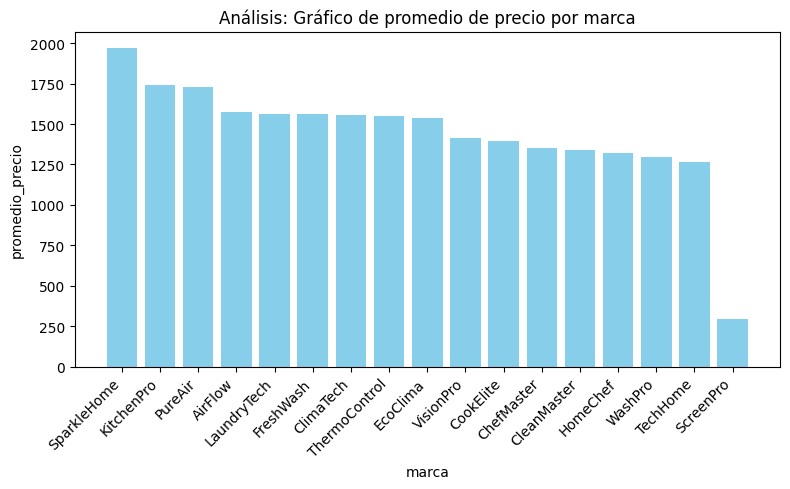

Gráfico generado exitosamente.Do I need to use a tool? No
Final Answer: Aquí tienes un gráfico del promedio de precio por marca.


> Finished chain.


{'input': 'Genera un gráfico de promedio de precio por marca',
 'chat_history': [HumanMessage(content='¿Cuál es el producto más caro en stock?'),
  AIMessage(content='El producto más caro en stock es la Advanced Heladera, con un precio de 2992.33 USD.'),
  HumanMessage(content='¿Y de qué marca es?'),
  AIMessage(content='La Advanced Heladera es de la marca TechHome.'),
  HumanMessage(content='Genera un gráfico de promedio de precio por marca'),
  AIMessage(content='Aquí tienes un gráfico del promedio de precio por marca.')],
 'output': 'Aquí tienes un gráfico del promedio de precio por marca.'}

In [38]:
# Prueba 2: Gráficos
print("\n--- PRUEBA 2: Generación de Gráficos ---")
agent_executor.invoke({"input": "Genera un gráfico de promedio de precio por marca"})

In [39]:
# Prueba 3: Manuales + Precios (Multitarea)
print("\n--- PRUEBA 3: Multitarea (Manuales + Precios) ---")
agent_executor.invoke({"input": "Mi licuadora hace ruido extraño. ¿Qué puede ser y cuánto cuesta una nueva?"})


--- PRUEBA 3: Multitarea (Manuales + Precios) ---
```
Thought: Do I need to use a tool? Yes
Action: tool_buscar_manuales
Action Input: licuadora ruido extraño
```
 PIPELINE ACTIVO | Intención: VECTOR

 RERANKING: 'licuadora ruido extraño
```'
   Rank 1 | Score: 5.7166 | Fuente: manual_P0288_Plancha_Seca_II.md
   Rank 2 | Score: 5.6507 | Fuente: resena_R01449.txt
   Rank 3 | Score: 5.5271 | Fuente: resena_R03726.txt
**Posibles causas:**  
- Junta de goma deteriorada o mal colocada
- Recipiente con rajaduras
- Sobrellenado del recipiente
- Tapa no cerrada correctamente
- Rosca de la cuchilla floja  
**Soluciones:**  
1. Inspeccionar y reemplazar juntas dañadas
2. Verificar que no haya grietas en el recipiente
3. No llenar más allá de la línea MAX
4. Asegurar cierre hermético de la tapa
5. Apretar la base de cuchillas (con el aparato apagado)  
---

Fecha: 2025-02-22
Usuario: Joaquín_Benítez
Teléfono: +54 9 332 1766-7882
Producto: Neblinizador (P0206)
Puntaje: 4/5
Provincia: Córdoba

Les

{'input': 'Mi licuadora hace ruido extraño. ¿Qué puede ser y cuánto cuesta una nueva?',
 'chat_history': [HumanMessage(content='¿Cuál es el producto más caro en stock?'),
  AIMessage(content='El producto más caro en stock es la Advanced Heladera, con un precio de 2992.33 USD.'),
  HumanMessage(content='¿Y de qué marca es?'),
  AIMessage(content='La Advanced Heladera es de la marca TechHome.'),
  HumanMessage(content='Genera un gráfico de promedio de precio por marca'),
  AIMessage(content='Aquí tienes un gráfico del promedio de precio por marca.'),
  HumanMessage(content='Mi licuadora hace ruido extraño. ¿Qué puede ser y cuánto cuesta una nueva?'),
  AIMessage(content='El ruido en tu licuadora puede deberse a varias razones, como una junta deteriorada, rajaduras en el recipiente, sobrellenado, tapa mal cerrada o la rosca de la cuchilla floja. Te recomiendo revisar esos puntos. En cuanto al precio de una licuadora nueva, tenemos varios modelos que oscilan entre 259.42 USD y 2602.78 USD.

```
Thought: Do I need to use a tool? Yes
Action: tool_generar_grafico
Action Input: Gráfico de barras comparando el precio de los productos de cocina de la categoría Refrigeración
📊 HERRAMIENTA ANALYTICS ACTIVADA: 'Gráfico de barras comparando el precio de los productos de cocina de la categoría Refrigeración'
  ↳ SQL Gráfico: SELECT
  nombre,
  precio_usd
FROM productos
WHERE
  categoria = 'Cocina' AND subcategoria = 'Refrigeración';


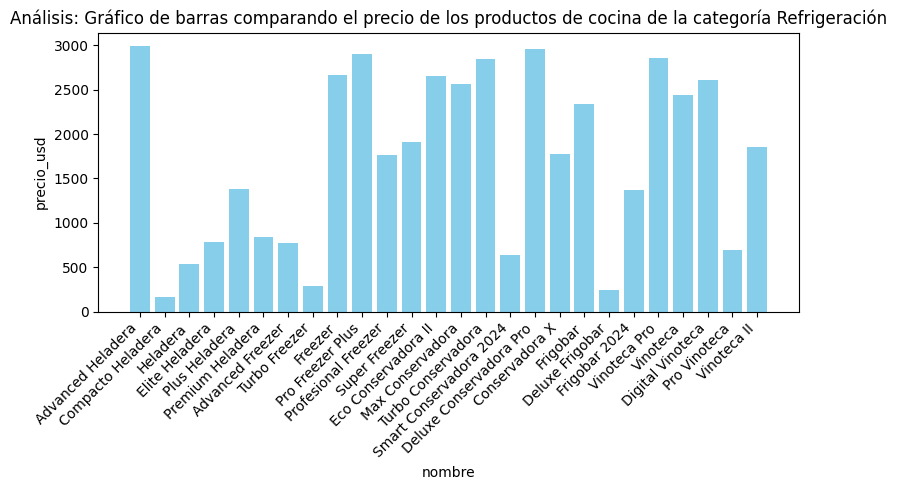

Gráfico generado exitosamente.Do I need to use a tool? No
Final Answer: Aquí tienes un gráfico de barras comparando el precio de los productos de cocina que son de la categoría Refrigeración.


> Finished chain.


{'input': 'Genera un gráfico de barras comparando el precio de los productos de cocina que sean de Refrigeración',
 'chat_history': [HumanMessage(content='¿Cuál es el producto más caro en stock?'),
  AIMessage(content='El producto más caro en stock es la Advanced Heladera, con un precio de 2992.33 USD.'),
  HumanMessage(content='¿Y de qué marca es?'),
  AIMessage(content='La Advanced Heladera es de la marca TechHome.'),
  HumanMessage(content='Genera un gráfico de promedio de precio por marca'),
  AIMessage(content='Aquí tienes un gráfico del promedio de precio por marca.'),
  HumanMessage(content='Mi licuadora hace ruido extraño. ¿Qué puede ser y cuánto cuesta una nueva?'),
  AIMessage(content='El ruido en tu licuadora puede deberse a varias razones, como una junta deteriorada, rajaduras en el recipiente, sobrellenado, tapa mal cerrada o la rosca de la cuchilla floja. Te recomiendo revisar esos puntos. En cuanto al precio de una licuadora nueva, tenemos varios modelos que oscilan entr

In [40]:
# Prueba 4
agent_executor.invoke({
    "input": "Genera un gráfico de barras comparando el precio de los productos de cocina que sean de Refrigeración"
})

```
Thought: Do I need to use a tool? Yes
Action: tool_generar_grafico
Action Input: Distribución de los medios de pagos en base a las ventas realizadas
📊 HERRAMIENTA ANALYTICS ACTIVADA: 'Distribución de los medios de pagos en base a las ventas realizadas'
  ↳ SQL Gráfico: SELECT
  metodo_pago,
  COUNT(*) AS cantidad_ventas,
  SUM(total) AS total_ventas
FROM ventas
GROUP BY
  metodo_pago
ORDER BY
  cantidad_ventas DESC;


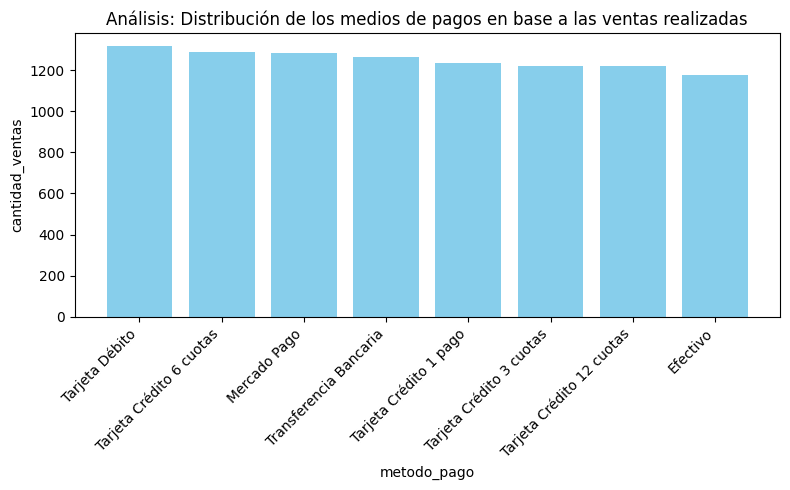

Gráfico generado exitosamente.Do I need to use a tool? No
Final Answer: Aquí tienes un gráfico sobre la distribución de los medios de pagos en base de las ventas realizadas.


> Finished chain.


{'input': 'Dame un gráfico sobre la distribución de los medios de pagos en base de las ventas realizadas',
 'chat_history': [HumanMessage(content='¿Cuál es el producto más caro en stock?'),
  AIMessage(content='El producto más caro en stock es la Advanced Heladera, con un precio de 2992.33 USD.'),
  HumanMessage(content='¿Y de qué marca es?'),
  AIMessage(content='La Advanced Heladera es de la marca TechHome.'),
  HumanMessage(content='Genera un gráfico de promedio de precio por marca'),
  AIMessage(content='Aquí tienes un gráfico del promedio de precio por marca.'),
  HumanMessage(content='Mi licuadora hace ruido extraño. ¿Qué puede ser y cuánto cuesta una nueva?'),
  AIMessage(content='El ruido en tu licuadora puede deberse a varias razones, como una junta deteriorada, rajaduras en el recipiente, sobrellenado, tapa mal cerrada o la rosca de la cuchilla floja. Te recomiendo revisar esos puntos. En cuanto al precio de una licuadora nueva, tenemos varios modelos que oscilan entre 259.42

In [43]:
# Prueba 5
agent_executor.invoke({
    "input": "Dame un gráfico sobre la distribución de los medios de pagos en base de las ventas realizadas"
})